In [171]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [172]:
def step(t, dt):
    t = t + dt
    return t

In [173]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            
#                     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#                     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

In [174]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [175]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below

        if self.view_max > end_row:
            self.view_max = end_row + self.width / 2
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [176]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [177]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n, max_vel, max_accel):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # akes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
                    
            elif self.unloadFlag == 1: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)

        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
#         # stop the arm from moving below the bottom of the frame
        if self.q_a[2] < self.q_f[2] - self.height_f / 2:
            self.q_a[2] = self.q_f[2]
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.q_a[0] < self.q_f[0]-0.001:  
#         print("").ocation: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
                
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
#                 print("DOES IT UNLOAD?")
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
                
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop of fthe fruit or fruit cannot be reached
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
                # reset the unloading flag 
                self.unloadFlag = 0
                        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [178]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [179]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 12.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [180]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.005])   # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

qv0 = []
qv1 = []

In [181]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [182]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [183]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

max_v = 1.
max_a = 10.

arm_offset = 0.75 / (num_row_arms-1) # divide by num of arms because it's going to be inverted diagonal vs row num

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        # fruit's in a diagonal, so get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_a[0] + 0.3 + ((num_row_arms-1)*arm_offset - arm_offset*rows)  
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows, max_v, max_a)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [184]:
## start timer to see how long code takes to execute
start_time = time.time()

# should_reach = 0

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)
                      
                    ####==> The following is not the limiting factor... which makes sense. 50 sec is huge!
                    ####==> Actually dropped total fruit picked
                        # now check that there is enough time to get to the fruit => one of the constraints?
#                         Tx = a[rows,arm_free].x.Ta + a[rows,arm_free].x.Tv + a[rows,arm_free].x.Td
#                         Ty = a[rows,arm_free].y.Ta + a[rows,arm_free].y.Tv + a[rows,arm_free].y.Td 
#                         Tz = a[rows,arm_free].z.Ta + a[rows,arm_free].z.Tv + a[rows,arm_free].z.Td
                        
#                         T_move = max(Ty, Tz) + Tx # time to get to the fruit
                        
#                         # calculate how long until fruit's unreachable
#                         d_edge  = a[rows,arm_free].y_edges_f[1] # location of back edge
#                         d_fruit = fruit.sortedFruit[1,goal_new] # location of fruit
#                         T_pass_fruit = (d_fruit - d_edge) / v_v[1]
                        
#                         print("Edge location:", d_edge, "Fruit Location:", d_fruit, "vehicle speed:", v_v[1])
                        
#                         if T_move >= T_pass_fruit:
#                             print("Won't reach")
# #                             # remove as goal
# #                             a[rows,arm_free].free = 1
# #                             # remove "picked" flag
# #                             fruit.sortedFruit[3,goal_new] = 0
#                         else:
#                             print("Time to fruit:", T_move, "Time left:", T_pass_fruit)
#                             should_reach += 1
                         
                    
                except ValueError:

                    print("*** No value came up, broke out of the if statement ***")
                    print("Potential key:", potential_key, "(back edge), next fruit:", )
                    break

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 7.35 9.8678696059 0.0
start, end, start velocity: 6.0 5.3231695488 0.0
start, end, start velocity: 1.5 1.1919865482 0.0
start, end, start velocity: 7.35 9.9191284757 0.0
start, end, start velocity: 9.0 7.5732524703 0.0
start, end, start velocity: 1.5 1.4549112491 0.0
start, end, start velocity: 7.35 9.0836432909 0.0
start, end, start velocity: 12.0 10.794768294 0.0
start, end, start velocity: 1.5 0.9577824011 0.0
start, end, start velocity: 6.975 7.8880462924 0.0
start, end, start velocity: 6.0 5.9278863172 0.0
start, end, start velocity: 4.5 4.2075675354 0.0
start, end, start velocity: 6.975 8.2155859972 0.0
start, end, start velocity: 9.0 7.5099152899 0.0
start, end, start velocity: 4.5 3.7314053709 0.0
start, end, start velocity: 6.975 7.7962720949 0.0
start, end, start velocity: 12.0 10.5610279055 0.0
start, end, start velocity: 4.5 4.0949260327 0.0
start, end, start velocity: 6.6 7.5979936552 0.0
start, end, start velocity: 6.0 6.0434705216 0.0
start, e

start, end, start velocity: 2.495682784300012 0.0 0.0
start, end, start velocity: 8.585738780299975 6.0 0.0
start, end, start velocity: 7.610857839799889 6.975 0
start, end, start velocity: 5.324488903400115 3.0 0.0
start, end, start velocity: 9.837921978699562 7.35 0
start, end, start velocity: 6.60000000000011 6.8409737365 0.0
start, end, start velocity: 6.312715847546524 6.3944639822 0.0
start, end, start velocity: 6.0000000000003695 8.3848979665 0.0
start, end, start velocity: 8.21703884869978 6.975 0
start, end, start velocity: 7.350000000000296 10.3387145256 0.0
start, end, start velocity: 5.502195418511659 5.509697613 0.0
start, end, start velocity: 3.9874928445954305e-13 1.4868856221 0.0
start, end, start velocity: 7.350000000000296 10.3246181674 0.0
start, end, start velocity: 5.5022454185116585 5.5709658081 0.0
start, end, start velocity: 3.9874928445954305e-13 1.4603149657 0.0
start, end, start velocity: 7.350000000000296 8.8590168127 0.0
start, end, start velocity: 5.502295

start, end, start velocity: 7.35 9.7717373544 0.0
start, end, start velocity: 7.974342869800025 8.0225264527 0.0
start, end, start velocity: 1.5 1.0307362359 0.0
start, end, start velocity: 9.70769061280042 7.35 0
start, end, start velocity: 6.6 7.2901099359 0.0
start, end, start velocity: 6.784587877600045 7.387423079 0.0
start, end, start velocity: 7.5 7.0157602714 0.0
start, end, start velocity: 2.39901894070017 0.0 0.0
start, end, start velocity: 8.302138264400236 6.975 0
start, end, start velocity: 7.88675304370023 6.6 0
start, end, start velocity: 0.5443941080998103 0.0 0.0
start, end, start velocity: 7.290109935900125 6.6 0
start, end, start velocity: 9.356588393400424 6.975 0
start, end, start velocity: 3.477485044999817 3.0 0.0
start, end, start velocity: 9.771737354400434 7.35 0
start, end, start velocity: 7.35 9.8647269861 0.0
start, end, start velocity: 11.418451415863261 11.4363323108 0.0
start, end, start velocity: 1.5 0.5360386943 0.0
start, end, start velocity: 7.35 8.3

start, end, start velocity: 6.975000000000845 7.8516511945 0.0
start, end, start velocity: 11.362230816734195 11.4035717822 0.0
start, end, start velocity: 3.000000000000073 5.2706588049 0.0
start, end, start velocity: 7.739670939099074 6.0 0.0
start, end, start velocity: 7.78364269939957 6.975 0
start, end, start velocity: 4.846062648199016 3.0 0.0
start, end, start velocity: 1.0766735526994482 0.0 0.0
start, end, start velocity: 1.098068898799438 0.0 0.0
start, end, start velocity: 6.600000000000563 7.7224076075 0.0
start, end, start velocity: 12.117599884808913 12.1272206276 0.0
start, end, start velocity: 6.0000000000009255 7.1395436973 0.0
start, end, start velocity: 8.977563915699132 7.35 0
start, end, start velocity: 7.12503298179972 6.6 0
start, end, start velocity: 7.350000000000824 9.7761535425 0.0
start, end, start velocity: 5.8429727789882 5.8784414311 0.0
start, end, start velocity: 5.517415951200588e-13 0.9231513818 0.0
start, end, start velocity: 7.350000000000893 9.9114

start, end, start velocity: 7.947289556599481 6.975 0
start, end, start velocity: 7.5264664521997044 6.975 0
start, end, start velocity: 7.694441607899416 6.6 0
start, end, start velocity: 1.1430550443994125 0.0 0.0
start, end, start velocity: 7.350000000000984 9.333058669 0.0
start, end, start velocity: 8.34000939215794 8.520953055 0.0
start, end, start velocity: 5.364226857845766e-13 1.3094137722 0.0
start, end, start velocity: 5.465470256698685 3.0 0.0
start, end, start velocity: 5.271200033898786 3.0 0.0
start, end, start velocity: 7.235140664599342 6.0 0.0
start, end, start velocity: 7.350000000001138 8.9552660833 0.0
start, end, start velocity: 5.997235125594781 6.0769048174 0.0
start, end, start velocity: 5.874909391433147e-13 0.5534953153 0.0
start, end, start velocity: 7.068017263299751 6.6 0
start, end, start velocity: 6.600000000000584 7.7475483469 0.0
start, end, start velocity: 12.272746692923072 12.2906655173 0.0
start, end, start velocity: 6.000000000000659 7.4439576752 

start, end, start velocity: 6.576489356699181 6.0 0.0
start, end, start velocity: 6.975 8.0014659565 0.0
start, end, start velocity: 11.772884961058738 11.8009528641 0.0
start, end, start velocity: 4.5 5.6932471143 0.0
start, end, start velocity: 2.6346761271010157 0.0 0.0
start, end, start velocity: 6.975 7.8452567893 0.0
start, end, start velocity: 7.129613739700098 7.1631933393 0.0
start, end, start velocity: 4.5 4.792741176 0.0
start, end, start velocity: 7.35 9.2163129092 0.0
start, end, start velocity: 8.844498998100118 9.0254388372 0.0
start, end, start velocity: 1.5 1.7554104063 0.0
start, end, start velocity: 6.6 7.109786954 0.0
start, end, start velocity: 12.53815566396404 12.6140347116 0.0
start, end, start velocity: 7.5 6.6980961023 0.0
start, end, start velocity: 2.5997282801009796 0.0 0.0
start, end, start velocity: 7.845256789300775 6.975 0
start, end, start velocity: 6.6 6.9522710835 0.0
start, end, start velocity: 8.099082786100107 8.1067254472 0.0
start, end, start ve

start, end, start velocity: 6.6 6.9905282776 0.0
start, end, start velocity: 8.170407616682002 8.1722908088 0.0
start, end, start velocity: 7.5 8.0014405301 0.0
start, end, start velocity: 7.615843541600899 6.6 0
start, end, start velocity: 2.7916518632011575 0.0 0.0
start, end, start velocity: 7.753915343400687 6.975 0
start, end, start velocity: 7.36068964410034 6.975 0
start, end, start velocity: 6.990528277600349 6.6 0
start, end, start velocity: 1.698642627900173 0.0 0.0
start, end, start velocity: 5.872890575801218 3.0 0.0
start, end, start velocity: 8.962673767501432 7.35 0
start, end, start velocity: 8.001440530100446 6.0 0.0
start, end, start velocity: 3.699795206099288 3.0 0.0
start, end, start velocity: 7.1897134758997225 6.0 0.0
start, end, start velocity: 6.975 7.5533444245 0.0
start, end, start velocity: 7.342333191140591 7.3764353613 0.0
start, end, start velocity: 4.5 3.7549585635 0.0
start, end, start velocity: 7.35 9.7752470513 0.0
start, end, start velocity: 9.150931

start, end, start velocity: 8.99308052270146 7.35 0
start, end, start velocity: 7.148559882300482 6.6 0
start, end, start velocity: 6.6 7.728915465 0.0
start, end, start velocity: 12.962935789928776 13.0178787519 0.0
start, end, start velocity: 7.5 6.4394285812 0.0
start, end, start velocity: 6.183926207598834 6.0 0.0
start, end, start velocity: 6.6 7.0162089611 0.0
start, end, start velocity: 8.32696084925447 8.346086945 0.0
start, end, start velocity: 7.5 7.6638578335 0.0
start, end, start velocity: 8.761658676701256 7.35 0
start, end, start velocity: 6.975 8.2467002485 0.0
start, end, start velocity: 11.948052807746196 11.9567281846 0.0
start, end, start velocity: 4.5 4.491721847 0.0
start, end, start velocity: 6.975 8.720551808 0.0
start, end, start velocity: 7.872408900883322 7.9836538979 0.0
start, end, start velocity: 4.5 4.2202653589 0.0
start, end, start velocity: 0.82552278769939 0.0 0.0
start, end, start velocity: 7.016208961100366 6.6 0
start, end, start velocity: 7.35 8.70

start, end, start velocity: 6.723629243300108 6.6 0
start, end, start velocity: 4.399761075999908 3.0 0.0
start, end, start velocity: 7.595622972679681 6.0 0.0
start, end, start velocity: 0.8751194856994355 0.0 0.0
start, end, start velocity: 7.35 8.9634730017 0.0
start, end, start velocity: 9.584726029967301 9.5933745911 0.0
start, end, start velocity: 1.5 1.7217417595 0.0
start, end, start velocity: 7.20552607239974 6.0 0.0
start, end, start velocity: 4.239740559299767 3.0 0.0
start, end, start velocity: 7.35 8.3890582971 0.0
start, end, start velocity: 12.0987282924001 12.1285502649 0.0
start, end, start velocity: 1.5 1.3458712907 0.0
start, end, start velocity: 2.227831954900651 0.0 0.0
start, end, start velocity: 6.975 8.3907026344 0.0
start, end, start velocity: 8.10666159767564 8.1784441986 0.0
start, end, start velocity: 4.5 3.984503309 0.0
start, end, start velocity: 6.6 7.7525293554 0.0
start, end, start velocity: 13.306273027622568 13.3406396971 0.0
start, end, start velocit

start, end, start velocity: 2.5838712851009706 0.0 0.0
start, end, start velocity: 8.394968199500925 7.35 0
start, end, start velocity: 6.6 7.0960630193 0.0
start, end, start velocity: 13.604897692592905 13.6250874638 0.0
start, end, start velocity: 7.5 6.3326771283 0.0
start, end, start velocity: 9.16662647580161 7.35 0
start, end, start velocity: 7.7635349076010325 6.6 0
start, end, start velocity: 6.975 6.8845510608 0.0
start, end, start velocity: 12.296763150900107 12.3190344506 0.0
start, end, start velocity: 5.9617973048012995 5.9335115991 0.0
start, end, start velocity: 2.834397593701193 0.0 0.0
start, end, start velocity: 6.975 7.5905013667 0.0
start, end, start velocity: 12.318955628796393 12.3521057994 0.0
start, end, start velocity: 5.9336129972460405 5.7911472302 0.0
start, end, start velocity: 9.259991444602027 6.975 0
start, end, start velocity: 6.66749804909926 6.0 0.0
start, end, start velocity: 7.096063019300438 6.6 0
start, end, start velocity: 7.590501366700543 6.975

start, end, start velocity: 7.35 9.1957275606 0.0
start, end, start velocity: 12.427923365086498 12.4528051748 0.0
start, end, start velocity: 1.5 0.8330032491 0.0
start, end, start velocity: 6.975 8.0443174422 0.0
start, end, start velocity: 12.57288270732277 12.6433022514 0.0
start, end, start velocity: 4.5 5.3095355525 0.0
start, end, start velocity: 8.544612888200927 6.0 0.0
start, end, start velocity: 1.4563081760412047 0.0 0.0
start, end, start velocity: 6.6 7.2849096417 0.0
start, end, start velocity: 8.978181349963977 8.9853322471 0.0
start, end, start velocity: 7.5 6.2581294559 0.0
start, end, start velocity: 7.35 9.4399753253 0.0
start, end, start velocity: 7.033017278236327 7.0589818892 0.0
start, end, start velocity: 1.5 2.2189137857 0.0
start, end, start velocity: 9.060321447601849 6.975 0
start, end, start velocity: 7.35 8.8393557272 0.0
start, end, start velocity: 9.988825086188323 10.1281043381 0.0
start, end, start velocity: 1.5 1.3138856538 0.0
start, end, start veloc

start, end, start velocity: 6.6 7.2094226094 0.0
start, end, start velocity: 13.935697339662564 13.9560516354 0.0
start, end, start velocity: 7.5 7.253394267 0.0
start, end, start velocity: 7.34053978480066 6.6 0
start, end, start velocity: 6.975 7.587253023 0.0
start, end, start velocity: 12.821220885013945 12.836860973 0.0
start, end, start velocity: 4.5 5.0724049267 0.0
start, end, start velocity: 9.17954475820162 7.35 0
start, end, start velocity: 6.975 8.4667118565 0.0
start, end, start velocity: 8.512902420706446 8.5313880608 0.0
start, end, start velocity: 4.5 3.376449799 0.0
start, end, start velocity: 6.539543862299146 6.0 0.0
start, end, start velocity: 9.111435138601566 7.35 0
start, end, start velocity: 7.209422609400535 6.6 0
start, end, start velocity: 7.587253023000544 6.975 0
start, end, start velocity: 6.6 7.1187491971 0.0
start, end, start velocity: 9.327556025916685 9.3871786596 0.0
start, end, start velocity: 7.5 6.4928662589 0.0
start, end, start velocity: 7.253394

start, end, start velocity: 4.948137529800393 3.0 0.0
start, end, start velocity: 7.35 8.7708383555 0.0
start, end, start velocity: 12.979521644200169 13.0156303582 0.0
start, end, start velocity: 1.5 2.4158438463 0.0
start, end, start velocity: 6.945895925100304 6.6 0
start, end, start velocity: 7.314987612499838 6.0 0.0
start, end, start velocity: 6.144961351598798 6.0 0.0
start, end, start velocity: 6.6 6.6871015525 0.0
start, end, start velocity: 9.640920907732266 9.6802951908 0.0
start, end, start velocity: 7.5 6.4953365508 0.0
start, end, start velocity: 8.343046451001209 6.975 0
start, end, start velocity: 7.35 9.1642268959 0.0
start, end, start velocity: 7.293102434171125 7.3881997229 0.0
start, end, start velocity: 1.5 2.7074638198 0.0
start, end, start velocity: 8.781725324101274 7.35 0
start, end, start velocity: 6.6 7.160787494 0.0
start, end, start velocity: 14.375353252850326 14.3873687558 0.0
start, end, start velocity: 7.5 6.5945289455 0.0
start, end, start velocity: 6.

start, end, start velocity: 6.6 6.907529075 0.0
start, end, start velocity: 14.578776734995287 14.5870276142 0.0
start, end, start velocity: 7.5 7.9017935757 0.0
start, end, start velocity: 4.865373615000323 3.0 0.0
start, end, start velocity: 6.131690384800118 6.0 0.0
start, end, start velocity: 6.6 6.8901515847 0.0
start, end, start velocity: 10.113138961096205 10.1627814142 0.0
start, end, start velocity: 7.5 6.9574079167 0.0
start, end, start velocity: 6.907529075000269 6.6 0
start, end, start velocity: 8.115901871900677 7.35 0
start, end, start velocity: 7.901793575700358 6.0 0.0
start, end, start velocity: 6.890151584700259 6.6 0
start, end, start velocity: 8.792223751801611 6.975 0
start, end, start velocity: 2.873253534401228 0.0 0.0
start, end, start velocity: 6.957407916699518 6.0 0.0
start, end, start velocity: 6.975 8.2352995222 0.0
start, end, start velocity: 8.737748204628753 8.7700654037 0.0
start, end, start velocity: 4.5 4.852841871 0.0
start, end, start velocity: 6.6 

start, end, start velocity: 7.918798691901166 6.6 0
start, end, start velocity: 3.374694309199003 3.0 0.0
start, end, start velocity: 7.35 8.8313128858 0.0
start, end, start velocity: 13.594158937293088 13.6037304149 0.0
start, end, start velocity: 1.5 1.287848592 0.0
start, end, start velocity: 6.975 7.465361411 0.0
start, end, start velocity: 13.324931996920846 13.3433258798 0.0
start, end, start velocity: 4.5 5.7843014879 0.0
start, end, start velocity: 6.975 9.3413817931 0.0
start, end, start velocity: 8.973964818397246 8.9765928918 0.0
start, end, start velocity: 4.5 3.239231916 0.0
start, end, start velocity: 7.436885525909852 6.0 0.0
start, end, start velocity: 8.831312885801315 7.35 0
start, end, start velocity: 7.465361411000437 6.975 0
start, end, start velocity: 6.6 7.8780318357 0.0
start, end, start velocity: 14.78593461941021 14.7969340913 0.0
start, end, start velocity: 7.5 6.6698341758 0.0
start, end, start velocity: 5.784301487901139 3.0 0.0
start, end, start velocity: 

start, end, start velocity: 8.001937599800907 6.975 0
start, end, start velocity: 8.07065025440051 6.0 0.0
start, end, start velocity: 4.913339930400367 3.0 0.0
start, end, start velocity: 3.576570779099181 3.0 0.0
start, end, start velocity: 8.737775955201228 7.35 0
start, end, start velocity: 6.975 9.097175204 0.0
start, end, start velocity: 13.529384947712805 13.5305422916 0.0
start, end, start velocity: 4.5 3.6634634441 0.0
start, end, start velocity: 6.6 7.6026028622 0.0
start, end, start velocity: 15.032395363228584 15.0787533713 0.0
start, end, start velocity: 7.5 8.0826898298 0.0
start, end, start velocity: 6.975 7.4634880886 0.0
start, end, start velocity: 9.449548754258469 9.487951214 0.0
start, end, start velocity: 4.5 4.1829331383 0.0
start, end, start velocity: 1.3432755942998635 0.0 0.0
start, end, start velocity: 7.463488088600428 6.975 0
start, end, start velocity: 7.602602862200891 6.6 0
start, end, start velocity: 7.35 8.7005606911 0.0
start, end, start velocity: 13.7

start, end, start velocity: 2.8003344612011665 0.0 0.0
start, end, start velocity: 7.81499342950074 6.975 0
start, end, start velocity: 7.736610597001006 6.6 0
start, end, start velocity: 7.603753247500553 6.975 0
start, end, start velocity: 4.418000086187679 3.0 0.0
start, end, start velocity: 5.277631954100686 3.0 0.0
start, end, start velocity: 6.8915221605994645 6.0 0.0
start, end, start velocity: 6.975 9.0724282308 0.0
start, end, start velocity: 13.863132755902662 13.919784226 0.0
start, end, start velocity: 4.5 3.084709482 0.0
start, end, start velocity: 7.35 9.2248708224 0.0
start, end, start velocity: 13.905291061227265 13.9155868073 0.0
start, end, start velocity: 1.5 2.2410638736 0.0
start, end, start velocity: 6.6 7.5032066696 0.0
start, end, start velocity: 15.306223424382974 15.3703008806 0.0
start, end, start velocity: 7.5 6.125713525 0.0
start, end, start velocity: 6.975 7.8128558285 0.0
start, end, start velocity: 9.73878120751391 9.7940089514 0.0
start, end, start vel

start, end, start velocity: 0.9986222882995449 0.0 0.0
start, end, start velocity: 6.975 9.0028245839 0.0
start, end, start velocity: 13.997904985783093 14.0032925575 0.0
start, end, start velocity: 4.5 3.3823820023 0.0
start, end, start velocity: 8.43227826780129 6.975 0
start, end, start velocity: 7.35 8.5357927785 0.0
start, end, start velocity: 14.587822098700206 14.6612102183 0.0
start, end, start velocity: 1.5 1.2691240069 0.0
start, end, start velocity: 3.758341776499341 3.0 0.0
start, end, start velocity: 8.53579277850105 7.35 0
start, end, start velocity: 6.975 7.4584505729 0.0
start, end, start velocity: 10.291801230412927 10.3044539311 0.0
start, end, start velocity: 4.5 4.3299734526 0.0
start, end, start velocity: 1.2691240068997909 0.0 0.0
start, end, start velocity: 9.002824583901797 6.975 0
start, end, start velocity: 7.4584505729004285 6.975 0
start, end, start velocity: 4.329973452599846 3.0 0.0
start, end, start velocity: 7.35 9.5724887325 0.0
start, end, start veloci

start, end, start velocity: 6.975 7.3869473526 0.0
start, end, start velocity: 14.283207677347011 14.3222100199 0.0
start, end, start velocity: 4.5 4.9128888124 0.0
start, end, start velocity: 7.386947352600366 6.975 0
start, end, start velocity: 0.9278701646994811 0.0 0.0
start, end, start velocity: 4.912888812400366 3.0 0.0
start, end, start velocity: 7.35 9.2559150938 0.0
start, end, start velocity: 14.965764945360057 15.0167622922 0.0
start, end, start velocity: 1.5 1.364167355 0.0
start, end, start velocity: 6.975 8.1652535807 0.0
start, end, start velocity: 14.322149903946139 14.3695778483 0.0
start, end, start velocity: 4.5 5.2079644787 0.0
start, end, start velocity: 9.255915093801692 7.35 0
start, end, start velocity: 8.165253580701059 6.975 0
start, end, start velocity: 1.3641673549998818 0.0 0.0
start, end, start velocity: 5.2079644787006245 3.0 0.0
start, end, start velocity: 7.35 8.9189955263 0.0
start, end, start velocity: 15.016742342708845 15.0260649975 0.0
start, end, 

In [185]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("Should have been able to reach:", should_reach)
print("doesn't take into account that for a while there are no good targets")


program took: 13.764065742492676 sec
total internal time: 600.0099999995994
total vehicle distance moved: 5.700049999993008
total number of fruit in CSV file: 2638

vehicle speed: 0.005 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

total fruit reached for arm 0 in row 0 is 79
total fruit reached for arm 1 in row 0 is 97
total fruit reached for arm 2 in row 0 is 188
total fruit reached for arm 0 in row 1 is 207
total fruit reached for arm 1 in row 1 is 2
total fruit reached for arm 2 in row 1 is 224
total fruit reached for arm 0 in row 2 is 171
total fruit reached for arm 1 in row 2 is 1
total fruit reached for arm 2 in row 2 is 229
Total picked fruit: 1198  and sec/pick fruit: 0.5008430717859761
Should have been able to reach: 412
doesn't take into account that for a while there are no good targets


num runs 60001


<IPython.core.display.Javascript object>


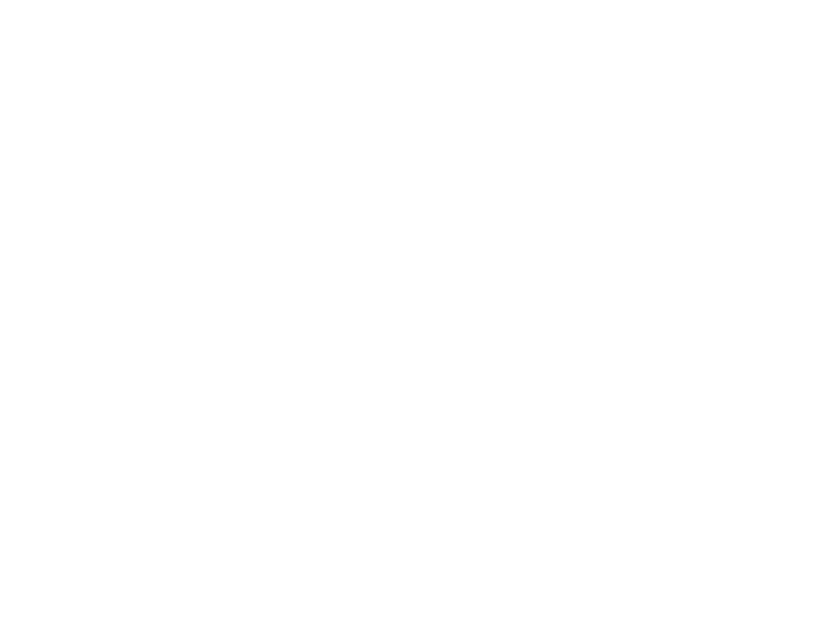

KeyboardInterrupt: 

In [153]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 30 == 0:
        ax.clear()
        
        for rows in range(num_row_arms):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
#                 dr.drawArmCylinder(center_y, center_z, arm_start, arm_end)
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [194]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[]
ROW 1
[]
ROW 2
[]
